<a href="https://colab.research.google.com/github/GlaucoLorenzut/facial-expression-recognition/blob/main/facial_expression_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Facial Expression Recognition

## Download the Dataset

Uploading the `kaggle.json` file to have access to the datasets from Kaggle from your local machine to the Google Colab environment. The file is then moved to the `/root/.kaggle`.

Using `!chmod 600 /root/.kaggle/kaggle.json` we set the permissions of the `kaggle.json` file to `600`, which means that the file is readable and writeable only by the owner. This is done for security purposes to prevent other users from accessing the file.

In [1]:
from google.colab import files
# Upload the kaggle.json file to the content directory
files.upload()

# Move the file kaggle.json from the content to the root directory
!mkdir -p /root/.kaggle
!mv /content/kaggle.json /root/.kaggle/kaggle.json
# Set the right permissions for the token
!chmod 600 /root/.kaggle/kaggle.json 

Saving kaggle.json to kaggle.json


Then we download the datasets and we move them in the new directory `/content/fer2013`

In [2]:
import zipfile
import tarfile

# Download all the FER 2013 competion data
!kaggle competitions download -c challenges-in-representation-learning-facial-expression-recognition-challenge

# Extract the ZIP file
with zipfile.ZipFile("challenges-in-representation-learning-facial-expression-recognition-challenge.zip", "r") as zip_ref:
    zip_ref.extractall("spam")

# Extract the tar.gz file
with tarfile.open("spam/fer2013.tar.gz", "r:gz") as tar:
    # extract all contents
    tar.extractall(path="spam")

# Move the csv file in the fer2013 folder
!mkdir -p ./fer2013
!mv spam/fer2013/fer2013.csv fer2013/fer2013.csv

#Remove all the other files
!rm challenges-in-representation-learning-facial-expression-recognition-challenge.zip
!rm -r spam

 97% 277M/285M [00:02<00:00, 140MB/s]
100% 285M/285M [00:02<00:00, 125MB/s]


In [3]:
# Download the FER+ csv from github (NOT USED)
#!wget https://github.com/microsoft/FERPlus/blob/master/fer2013new.csv
#!mv fer2013new.csv fer2013/fer2013new.csv

## Dataset Analysis

In [4]:
import pandas as pd

df = pd.read_csv("fer2013/fer2013.csv")
df.head(10)

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
5,2,55 55 55 55 55 54 60 68 54 85 151 163 170 179 ...,Training
6,4,20 17 19 21 25 38 42 42 46 54 56 62 63 66 82 1...,Training
7,3,77 78 79 79 78 75 60 55 47 48 58 73 77 79 57 5...,Training
8,3,85 84 90 121 101 102 133 153 153 169 177 189 1...,Training
9,2,255 254 255 254 254 179 122 107 95 124 149 150...,Training


In [5]:
# Dataset split as follow 

df['Usage'].value_counts()

Training       28709
PublicTest      3589
PrivateTest     3589
Name: Usage, dtype: int64

In [6]:
# The emotions in the fer2013 dataset are:
# 0. Angry
# 1. Disgust
# 2. Fear
# 3. Happy
# 4. Sad
# 5. Surprise
# 6. Neutral

# Emotions split as follow 

emotion_names = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]
emotion_counts = df['emotion'].value_counts().sort_index()

for emotion, count in emotion_counts.items():
    space = '\t' if len(emotion_names[emotion])>5 else '\t\t'
    print(f"{emotion_names[emotion]}:{space}{count}")

Angry:		4953
Disgust:	547
Fear:		5121
Happy:		8989
Sad:		6077
Surprise:	4002
Neutral:	6198


In [7]:
# Drop duplicate images focusing on deleting the Training ones

df = df.sort_values(by='Usage')
df = df.drop_duplicates(subset='pixels')

df['Usage'].value_counts()

Training       26942
PrivateTest     3572
PublicTest      3520
Name: Usage, dtype: int64

## Training Neural Network

In [8]:
!mkdir "./checkpoint" 

In [9]:
import pandas as pd
import time
import tensorflow as tf

epochs = 100
batch_size = 32
loss = "categorical_crossentropy"
activation_function = "relu"
learning_rate = 0.001
lr_decay = learning_rate / epochs
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9, nesterov=True)
drop=0.2


df = pd.read_csv("fer2013/fer2013.csv")

# Split the sets
training     = df.loc[df["Usage"] == "Training"]
private_test = df.loc[df["Usage"] == "PrivateTest"]
public_test  = df.loc[df["Usage"] == "PublicTest"]

# Obtain the images and the labels
import numpy as np
from keras.utils import to_categorical

def preprocess_data(data):
    labels = to_categorical(data["emotion"]) # one-hot arrays

    pixels = data["pixels"].str.split(" ").tolist()
    pixels = np.uint8(pixels)
    pixels = pixels.reshape((len(data["emotion"]), 48, 48, 1))
    pixels = pixels.astype("float32") / 255 # normalize pixels to 0-1

    return labels, pixels

training_labels, training_pixels         = preprocess_data(training)
private_test_labels, private_test_pixels = preprocess_data(private_test)
public_test_labels, public_test_pixels   = preprocess_data(public_test)

# Create the ImageDataGenerator object for data augmentation
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=10,
    horizontal_flip=True
)

# Add data generator to the training set
training_generator = datagen.flow(training_pixels, training_labels, batch_size=batch_size)


start = time.time()


# init cnn
model = tf.keras.Sequential()


# convolution
model.add(tf.keras.layers.Conv2D(64, kernel_size=(3, 3), input_shape=(48, 48, 1), padding='same'))
model.add(tf.keras.layers.BatchNormalization(axis=-1))
model.add(tf.keras.layers.Activation(activation_function))

model.add(tf.keras.layers.Conv2D(64, kernel_size=(3, 3), padding='same'))
model.add(tf.keras.layers.BatchNormalization(axis=-1))
model.add(tf.keras.layers.Activation(activation_function))

model.add(tf.keras.layers.MaxPooling2D(pool_size=2, strides=2))


model.add(tf.keras.layers.Conv2D(128, kernel_size=(3, 3), padding='same'))
model.add(tf.keras.layers.BatchNormalization(axis=-1))
model.add(tf.keras.layers.Activation(activation_function))

model.add(tf.keras.layers.Conv2D(128, kernel_size=(3, 3), padding='same'))
model.add(tf.keras.layers.BatchNormalization(axis=-1))
model.add(tf.keras.layers.Activation(activation_function))

model.add(tf.keras.layers.MaxPooling2D(pool_size=2, strides=2))


model.add(tf.keras.layers.Conv2D(256, kernel_size=(3, 3), padding='same'))
model.add(tf.keras.layers.BatchNormalization(axis=-1))
model.add(tf.keras.layers.Activation(activation_function))

model.add(tf.keras.layers.Conv2D(256, kernel_size=(3, 3), padding='same'))
model.add(tf.keras.layers.BatchNormalization(axis=-1))
model.add(tf.keras.layers.Activation(activation_function))

model.add(tf.keras.layers.MaxPooling2D(pool_size=2, strides=2))


model.add(tf.keras.layers.Conv2D(512, kernel_size=(3, 3), padding='same'))
model.add(tf.keras.layers.BatchNormalization(axis=-1))
model.add(tf.keras.layers.Activation(activation_function))

model.add(tf.keras.layers.Conv2D(512, kernel_size=(3, 3), padding='same'))
model.add(tf.keras.layers.BatchNormalization(axis=-1))
model.add(tf.keras.layers.Activation(activation_function))

model.add(tf.keras.layers.MaxPooling2D(pool_size=2, strides=2))


# add dense layers
model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(units=4096))
model.add(tf.keras.layers.Dropout(rate=drop))
model.add(tf.keras.layers.Activation(activation_function))

model.add(tf.keras.layers.Dense(units=4096))
model.add(tf.keras.layers.Dropout(rate=drop))
model.add(tf.keras.layers.Activation(activation_function))
model.add(tf.keras.layers.Dense(units=7))
model.add(tf.keras.layers.Activation("softmax"))


#callbacks

def lr_time_based_decay_scheduler(epoch, lr):
    return lr * 1 / (1 + lr_decay * epoch)

lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_time_based_decay_scheduler, verbose=1)
es_callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', min_delta=0.001, patience=5, verbose=1, mode='max', restore_best_weights=True) # stop training after less than 0.0001 increasing of accuracy

# launch cnn
model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=["accuracy"]
)

hist = model.fit(
                training_generator,
                epochs=epochs,
                validation_data=(private_test_pixels, private_test_labels),
                callbacks=[lr_callback, es_callback]
                )

test_loss, test_accuracy = model.evaluate(
    public_test_pixels,
    public_test_labels
    )

elapsed_time = time.time() - start

min, sec = divmod(elapsed_time, 60)
print("CNN training time: ", f"{int(min):02} min {int(sec):02} sec")
print("public test acc  -> ", test_accuracy)
print("public test loss -> ", test_loss)


Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/100
898/898 [==============================] - 41s 35ms/step - loss: 1.6535 - accuracy: 0.3560 - val_loss: 1.4804 - val_accuracy: 0.4196 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0009999900475969753.
Epoch 2/100
898/898 [==============================] - 32s 35ms/step - loss: 1.3936 - accuracy: 0.4638 - val_loss: 1.3350 - val_accuracy: 0.4840 - lr: 9.9999e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0009999700363790467.
Epoch 3/100
898/898 [==============================] - 31s 34ms/step - loss: 1.2712 - accuracy: 0.5097 - val_loss: 1.3303 - val_accuracy: 0.4937 - lr: 9.9997e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0009999400141439956.
Epoch 4/100
898/898 [==============================] - 31s 35ms/step - loss: 1.1862 - accuracy: 0.5503 - val_loss: 1.2208 - val_accuracy: 0.5171 - lr: 9.9994e-04

Epoch 5: LearningRateScheduler sett

## Results

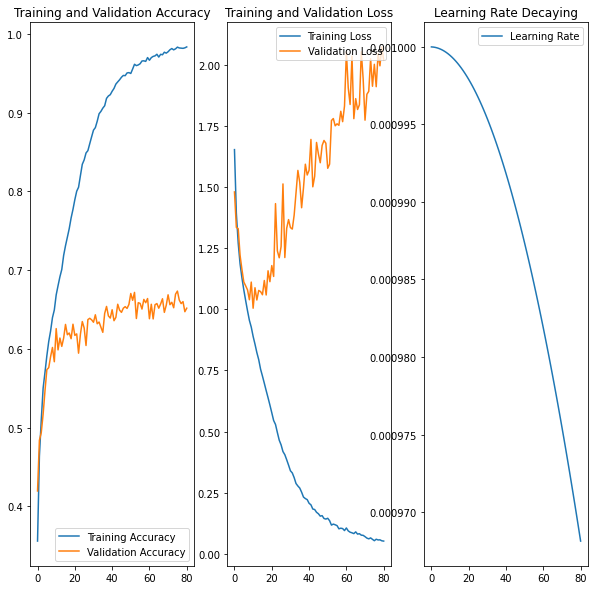

In [15]:
import matplotlib.pyplot as plt

epochs_range = range(len(hist.history['accuracy']))

acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
loss = hist.history['loss']
val_loss = hist.history['val_loss']
lr = hist.history['lr']

plt.figure(figsize=(10, 10))
#plt.subplots_adjust(wspace=2)

plt.subplot(1, 3, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 3, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.subplot(1, 3, 3)
plt.plot(epochs_range, lr, label='Learning Rate')
plt.legend(loc='upper right')
plt.title('Learning Rate Decaying')
plt.show()

113/113 [==============================] - 1s 9ms/step


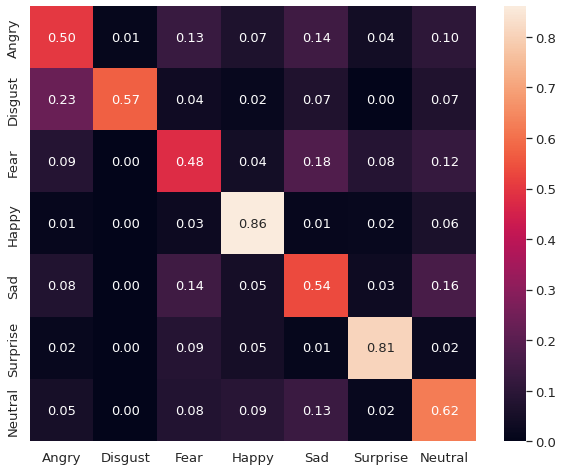

In [16]:
import numpy as np
import seaborn as sn
import pandas as pd
from sklearn.metrics import confusion_matrix

emotion_names = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]

# Calculate the confusion matrix for the public test set
predictions = model.predict(public_test_pixels)
predictions = np.argmax(predictions, axis=1)
y_true = np.argmax(public_test_labels, axis=1)
confusion_matrix = confusion_matrix(y_true, predictions)

# Normalize the confusion matrix
confusion_matrix = confusion_matrix.astype("float") / confusion_matrix.sum(axis=1)[:, np.newaxis]

# Transform the confusion matrix into a Pandas DataFrame for easier plotting with Seaborn
df_cm = pd.DataFrame(confusion_matrix, emotion_names, emotion_names)

# Plot the confusion matrix with Seaborn
plt.figure(figsize=(10,8))
sn.set(font_scale=1.2) # increase font size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 13}, fmt=".2f") # create the plot with annotations
plt.show()

1/1 [==============================] - 0s 360ms/step


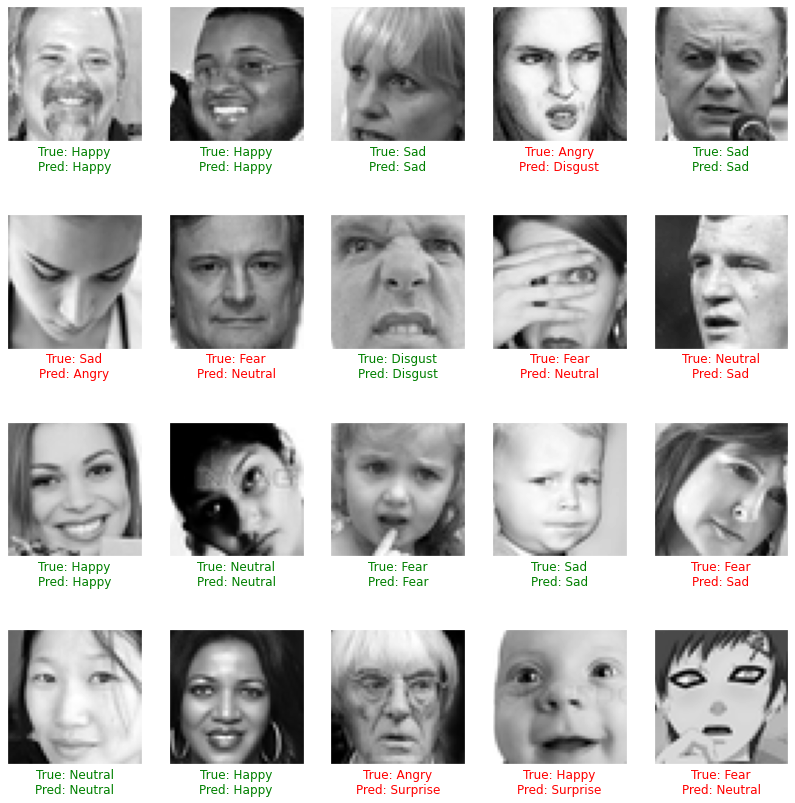

In [17]:
import matplotlib.pyplot as plt

emotion_names = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]

# Choose a random subset of images
sample_size = 20
random_idx = np.random.randint(0, public_test_pixels.shape[0], size=sample_size)
sample_images = public_test_pixels[random_idx]
sample_labels = public_test_labels[random_idx]

# Predict labels for the sample images
predictions = model.predict(sample_images)
predicted_labels = np.argmax(predictions, axis=1)

# Display the images and labels
fig, axs = plt.subplots(4, 5, figsize=(14,14))
plt.subplots_adjust(hspace=0.5)
for i, ax in enumerate(axs.flat):
    ax.imshow(sample_images[i, :, :, 0], cmap='gray')

    true_label = emotion_names[np.argmax(sample_labels[i])]
    predicted_label = emotion_names[predicted_labels[i]]
    color = "green" if predicted_label == true_label else "red"

    ax.set_xlabel(f"True: {true_label}\nPred: {predicted_label}", fontsize=12, color=color)
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()